In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from cytoolz import pipe

from pyrlmala.learning import LearningFactory
from pyrlmala.learning.callback import Callback
from pyrlmala.utils import Toolbox
from pyrlmala.utils.plot import AveragePolicy

In [2]:
plot_agent_500 = partial(Toolbox.plot_agent, steps_per_episode=500)

In [3]:
model_name = "test-laplace_4_wide-test-laplace_4_wide"
posteriordb_path = "../posteriordb/posterior_database"

In [4]:
sample_dim = 2
initial_sample = 0.1 * np.ones(sample_dim)
initial_step_size = np.array([1.0])
algorithm = "ddpg"
mcmc_env = "mala"
runtime_config_path = f"./config/runtime_{mcmc_env}.toml"

learning_instance = LearningFactory.create_learning_instance(
    algorithm=algorithm,
    model_name=model_name,
    posteriordb_path=posteriordb_path,
    initial_sample=initial_sample,
    initial_step_size=initial_step_size,
    hyperparameter_config_path=f"./config/{algorithm}_{mcmc_env}/{algorithm}_{mcmc_env}_seed_0.toml",
    actor_config_path="./config/actor.toml",
    critic_config_path="./config/critic.toml",
)

/home/laurence/Code/PythonProjects/pyrlmala/.venv/lib/python3.12/site-packages/bridgestan/model.py:140: UserWarning: Loading a shared object /home/laurence/Code/PythonProjects/pyrlmala/experiments/posteriordb/posterior_database/models/stan/test-laplace_4_wide_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the library!
  warnings.warn(
/home/laurence/Code/PythonProjects/pyrlmala/.venv/lib/python3.12/site-packages/bridgestan/model.py:140: UserWarning: Loading a shared object /home/laurence/Code/PythonProjects/pyrlmala/experiments/posteriordb/posterior_database/models/stan/test-laplace_4_wide_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the library!
  warnings.warn(


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

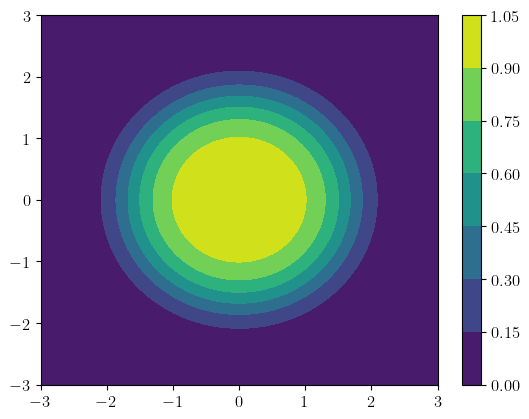

In [6]:
data_range = ((-3, 3, 100), (-3, 3, 100))
Toolbox.target_plot(data_range, learning_instance.env.envs[0].get_wrapper_attr("log_target_pdf"), save_path="./test-laplace_4_wide-test-laplace_4_wide_target_plot.pdf")

In [ ]:
x_range = (-3, 3, 0.1)
y_range = (-3, 3, 0.1)

policy = lambda x: learning_instance.actor(x.double())

Toolbox.policy_plot_2D_heatmap(policy, torch.arange(*x_range), torch.arange(*y_range))

In [ ]:
visualizer_and_actor_lr_instance = Callback(
    learning_instance,
    plot_frequency=100,
    num_of_mesh=10,
    auto_start=True,
    runtime_config_path=runtime_config_path,
    actor_folder_path=f"./weights/{mcmc_env}/actor",
    actor_save_after_steps=1,
    actor_save_frequency=10,
)

In [ ]:
visualizer_and_actor_lr_instance.train()

In [ ]:
Toolbox.policy_plot_2D_heatmap(policy, torch.arange(*x_range), torch.arange(*y_range))

In [ ]:
lower_window_size = 0
upper_window_size = learning_instance.env.envs[0].get_wrapper_attr("current_step") - 1

reward_item_plot = lambda tpl: plt.plot(tpl[1][lower_window_size:upper_window_size], label=f"{tpl[0]}", alpha=0.5)

pipe(
    learning_instance.env.envs[0],
    lambda env: (
        ("transient", env.get_wrapper_attr("reward_items")["transient"]),
        ("entropy", env.get_wrapper_attr("reward_items")["entropy"]),
        ("esjd", env.get_wrapper_attr("reward_items")["expected_square_jump_distance"])
    ),
    lambda tpl: (reward_item_plot(tpl[0]), reward_item_plot(tpl[1]), reward_item_plot(tpl[2])),
    lambda _: plt.legend(),
    lambda _: plt.show()
)

In [ ]:
accepted_sample = pipe(
    learning_instance,
    lambda x: getattr(x, "env"),
    lambda x: x.get_attr("store_accepted_sample"),
)[0]

plt.plot(
    accepted_sample[lower_window_size:upper_window_size, 0],
    accepted_sample[lower_window_size:upper_window_size, 1],
    'o-', alpha=0.1)
plt.show()

In [ ]:
pipe(learning_instance, lambda x: getattr(x, "critic_values"), plot_agent_500)

In [ ]:
pipe(learning_instance, lambda x: getattr(x, "critic_loss"), plot_agent_500)

In [ ]:
pipe(learning_instance, lambda x: getattr(x, "actor_loss"), plot_agent_500)

In [ ]:
reward = pipe(
    learning_instance,
    lambda x: getattr(x, "env"),
    lambda x: x.get_attr("store_reward")[0],
    Toolbox.reward_plot
)

In [ ]:
AveragePolicy.plot_policy(
    learning_instance.actor,
    f"./weights/{mcmc_env}/actor",
    data_range,
    1000,
    20,
    save_path=f"./{model_name}_{algorithm}_{mcmc_env}_average_policy.pdf"
)

In [ ]:
learning_instance.predict()

In [ ]:
gs = Toolbox.gold_standard(model_name, posteriordb_path)

In [ ]:
Toolbox.calculate_mmd(gs, learning_instance.predicted_observation, Toolbox.median_trick(gs))